In [ ]:
from pathlib import Path
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image
import torch.optim as optim
import time
import plotly.express as px
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data import Subset
import torch.nn as nn

In [46]:
class CloudSegmentationDataset(Dataset):
    def __init__(self, images_root_directory: Path, pytorch: bool, is_training_dataset: bool) -> None:
        super().__init__()

        self.images_root_directory = images_root_directory
        self.is_training_dataset = is_training_dataset
        self.files = self.create_files_list()
        self.pytorch = pytorch

    def create_files_list(self) -> list[dict[str, Path]]:
        # Combine file paths for different spectral bands into a dictionary
        if self.is_training_dataset:
            root = self.images_root_directory / "38-Cloud_training"
            prefix = "train"
        else:
            root = self.images_root_directory / "38-Cloud_test"
            prefix = "test"

        if not root.exists():
            raise FileNotFoundError(f"Directory {root} does not exist.")

        red_directory = root / f"{prefix}_red"

        files = []
        for file in red_directory.iterdir():
            if file.is_file():
                file_name = file.name
                files.append(
                    {
                        "red": red_directory / file_name,
                        "green": root / f"{prefix}_green" / file_name.replace("red", "green"),
                        "blue": root / f"{prefix}_blue" / file_name.replace("red", "blue"),
                        "nir": root / f"{prefix}_nir" / file_name.replace("red", "nir"),
                        "gt": root / f"{prefix}_gt" / file_name.replace("red", "gt"),
                    }
                )

        return files

    def __len__(self):
        # Return the number of files in the dataset
        return len(self.files)

    def open_as_array(self, image_index: int, include_nir: bool = False) -> np.ndarray:
        # Open image files as arrays, optionally including NIR channel
        raw_rgb = np.stack(
            [
                np.array(Image.open(self.files[image_index]["red"])),
                np.array(Image.open(self.files[image_index]["green"])),
                np.array(Image.open(self.files[image_index]["blue"])),
            ],
            axis=2,
        )

        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[image_index]["nir"])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)

        # Normalize pixel values
        return raw_rgb / np.iinfo(raw_rgb.dtype).max

    def open_mask(self, image_index: int, add_dims: bool = False) -> np.ndarray:
        # Open ground truth mask as an array
        raw_mask = np.array(Image.open(self.files[image_index]["gt"]))
        raw_mask = np.where(raw_mask == 255, 1, 0)

        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask

    def __getitem__(self, image_index: int) -> tuple[torch.Tensor, torch.Tensor]:
        entry = self.files[image_index]

        # Charger les 3 canaux RGB
        channels = []
        for band in ["red", "green", "blue"]:
            img = Image.open(entry[band])
            arr = np.array(img).astype(np.float32)
            arr = (arr - arr.min()) / (arr.max() - arr.min())  # Normalisation [0, 1]
            channels.append(arr)

        image = np.stack(channels, axis=0)  # (3, H, W)

        # Masque GT binaire
        mask = np.array(Image.open(entry["gt"])).astype(np.uint8)
        mask = (mask > 0).astype(np.float32)

        return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

    def open_as_pil(self, image_index: int) -> Image.Image:
        # Open an image as a PIL image
        arr = 256 * self.open_as_array(image_index)
        return Image.fromarray(arr.astype(np.uint8), "RGB")


In [3]:
data = CloudSegmentationDataset(
    images_root_directory=Path(r"C:\Users\giand\OneDrive\Documents\__packages__\_perso\satellite_data"),
    pytorch=True,
    is_training_dataset=True,
)
len(data)

8400

In [4]:
data.files[0]

{'red': WindowsPath('C:/Users/giand/OneDrive/Documents/__packages__/_perso/satellite_data/38-Cloud_training/train_red/red_patch_100_5_by_12_LC08_L1TP_061017_20160720_20170223_01_T1.TIF'),
 'green': WindowsPath('C:/Users/giand/OneDrive/Documents/__packages__/_perso/satellite_data/38-Cloud_training/train_green/green_patch_100_5_by_12_LC08_L1TP_061017_20160720_20170223_01_T1.TIF'),
 'blue': WindowsPath('C:/Users/giand/OneDrive/Documents/__packages__/_perso/satellite_data/38-Cloud_training/train_blue/blue_patch_100_5_by_12_LC08_L1TP_061017_20160720_20170223_01_T1.TIF'),
 'nir': WindowsPath('C:/Users/giand/OneDrive/Documents/__packages__/_perso/satellite_data/38-Cloud_training/train_nir/nir_patch_100_5_by_12_LC08_L1TP_061017_20160720_20170223_01_T1.TIF'),
 'gt': WindowsPath('C:/Users/giand/OneDrive/Documents/__packages__/_perso/satellite_data/38-Cloud_training/train_gt/gt_patch_100_5_by_12_LC08_L1TP_061017_20160720_20170223_01_T1.TIF')}

In [6]:
data.open_as_array(0, include_nir=True).shape

(384, 384, 4)

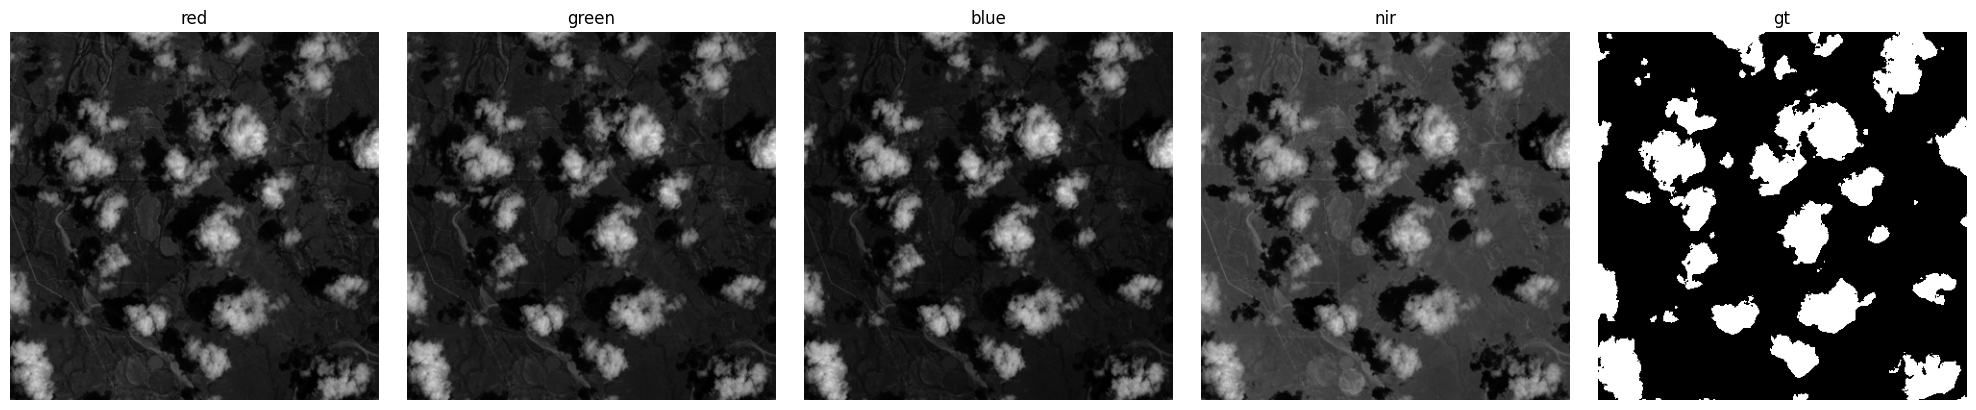

In [33]:
def show_images_matplotlib(file_entry: dict[str, Path]) -> None:
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))

    for ax, (key, path) in zip(axes, file_entry.items(), strict=True):
        if not path.exists():
            print(f"File {path} does not exist.")
            continue
        img = Image.open(path)
        arr = np.array(img)

        if len(arr.shape) == 2:  # grayscale
            ax.imshow(arr, cmap="gray")
        else:  # RGB
            ax.imshow(arr)

        ax.set_title(key)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


show_images_matplotlib(data.files[6])

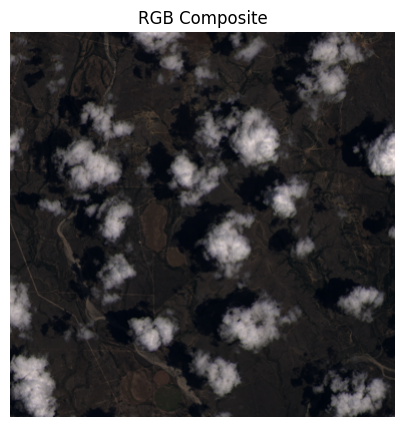

In [42]:
def show_rgb_composite(file_entry: dict[str, Path]) -> None:
    channels = []
    for color in ["red", "green", "blue"]:
        img = Image.open(file_entry[color])
        arr = np.array(img)

        if arr.dtype != np.uint16:
            raise ValueError(f"{color} channel is not in 16-bit format.")

        channels.append(arr)

    # Check if all channels have the same dimensions
    h, w = channels[0].shape
    if not all(c.shape == (h, w) for c in channels):
        raise ValueError("Channels do not have the same dimensions.")

    rgb16 = np.stack(channels, axis=-1)  # shape (H, W, 3), dtype uint16

    rgb_visu = ((rgb16 - rgb16.min()) / (rgb16.max() - rgb16.min()) * 255).astype(np.uint8)

    plt.figure(figsize=(5, 5))
    plt.imshow(rgb_visu)
    plt.title("RGB Composite")
    plt.axis("off")
    plt.show()


show_rgb_composite(data.files[6])

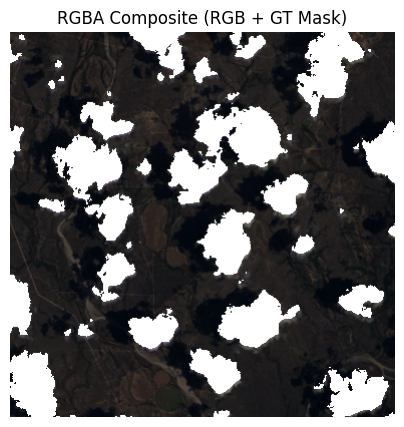

In [45]:
def show_rgb_with_gt_mask(file_entry: dict[str, Path]) -> None:
    channels = []
    for color in ["red", "green", "blue"]:
        img = Image.open(file_entry[color])
        arr = np.array(img, dtype=np.uint16)

        if arr.dtype != np.uint16:
            raise ValueError(f"{color} channel is not in 16-bit format.")

        channels.append(arr)

    h, w = channels[0].shape
    if not all(c.shape == (h, w) for c in channels):
        raise ValueError("RGB channels are not of the same size.")

    rgb16 = np.stack(channels, axis=-1)  # shape (H, W, 3), dtype uint16

    # gt becomes the alpha but we must invert it because the mask is white on clouds
    gt = np.array(Image.open(file_entry["gt"]))
    if gt.shape != (h, w):
        raise ValueError("gt mask size does not match RGB images.")

    # Binariser l'alpha si nécessaire
    if gt.max() > 1:
        alpha = (gt > 0).astype(np.uint16) * 65535
    else:
        alpha = (gt > 0).astype(np.uint16) * 65535

    alpha = 65535 - alpha  # Invert alpha mask to show clouds as transparent

    # Normalized RGB and alpha channels for visualization
    rgb_visu = ((rgb16 - rgb16.min()) / (rgb16.max() - rgb16.min()) * 255).astype(np.uint8)
    alpha_visu = (alpha / 65535 * 255).astype(np.uint8)
    rgba_visu = np.dstack((rgb_visu, alpha_visu))

    plt.figure(figsize=(5, 5))
    plt.imshow(rgba_visu)
    plt.title("RGBA Composite (RGB + GT Mask)")
    plt.axis("off")
    plt.show()


show_rgb_with_gt_mask(data.files[6])


---

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class SimpleUNet(nn.Module):
    def __init__(self, in_channels: int = 3, out_channels: int = 1) -> None:
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(128, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        bottleneck = self.bottleneck(self.pool2(enc2))

        dec2 = self.up2(bottleneck)
        dec2 = self.dec2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.up1(dec2)
        dec1 = self.dec1(torch.cat([dec1, enc1], dim=1))

        return self.final(dec1)


def train_one_epoch(
    model: SimpleUNet,
    dataloader: DataLoader,
    optimizer: optim.Adam,
    criterion: nn.BCEWithLogitsLoss,
    device: torch.device,
) -> float:
    model.train()
    total_loss = 0
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = CloudSegmentationDataset(
    images_root_directory=Path(r"C:\Users\giand\OneDrive\Documents\__packages__\_perso\satellite_data"),
    pytorch=True,
    is_training_dataset=True,
)

subset = Subset(dataset, range(0, 10))  # use a small subset for quick training
dataloader = DataLoader(subset, batch_size=4, shuffle=True)

model = SimpleUNet(in_channels=3, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss()  # car binaire
optimizer = optim.Adam(model.parameters(), lr=1e-3)

number_of_epochs = 2
for epoch in range(number_of_epochs):
    loss = train_one_epoch(model, dataloader, optimizer, criterion, device)
    print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")

torch.save(model.state_dict(), f"models/{time.strftime('%Y%m%d')}_unet_{number_of_epochs}_epochs.pth")


Epoch 1, Loss: 0.5197
Epoch 2, Loss: 0.3655


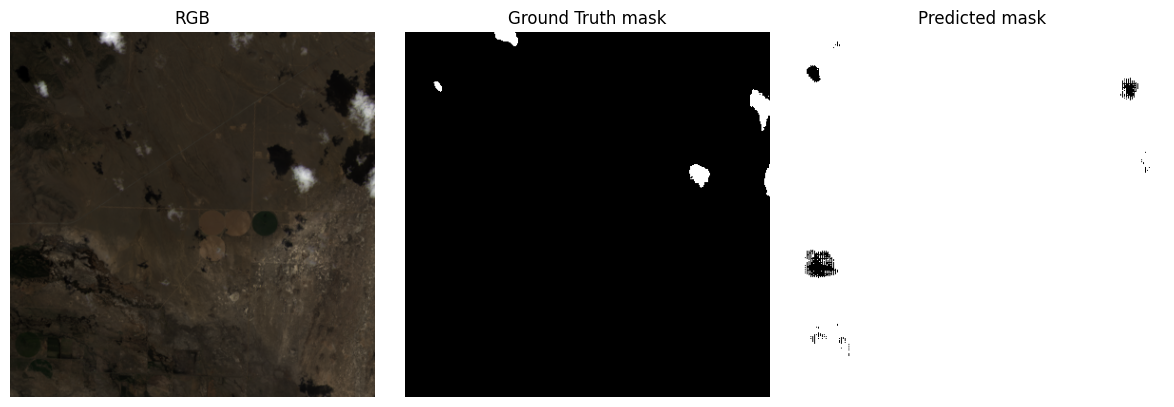

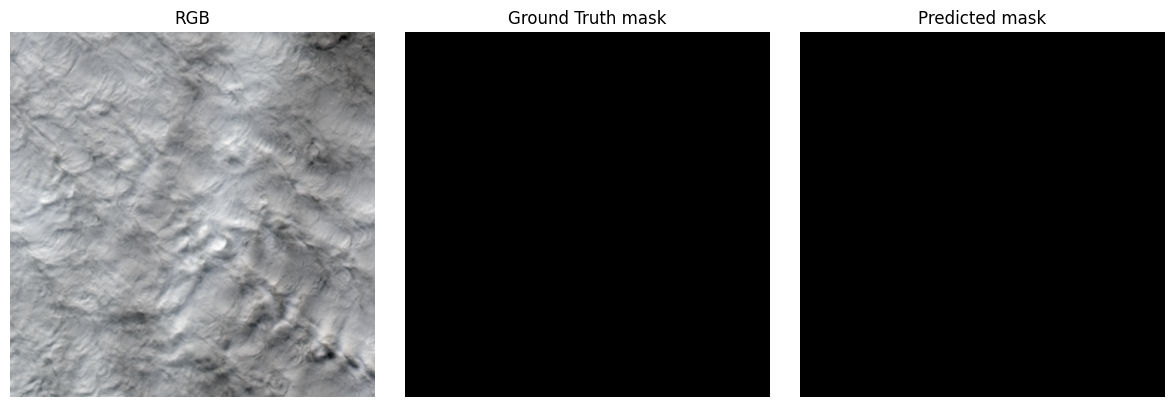

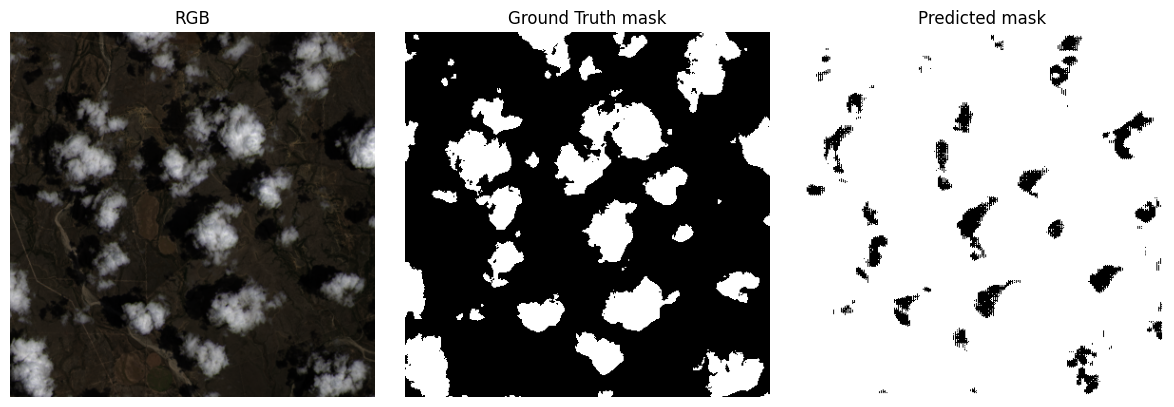

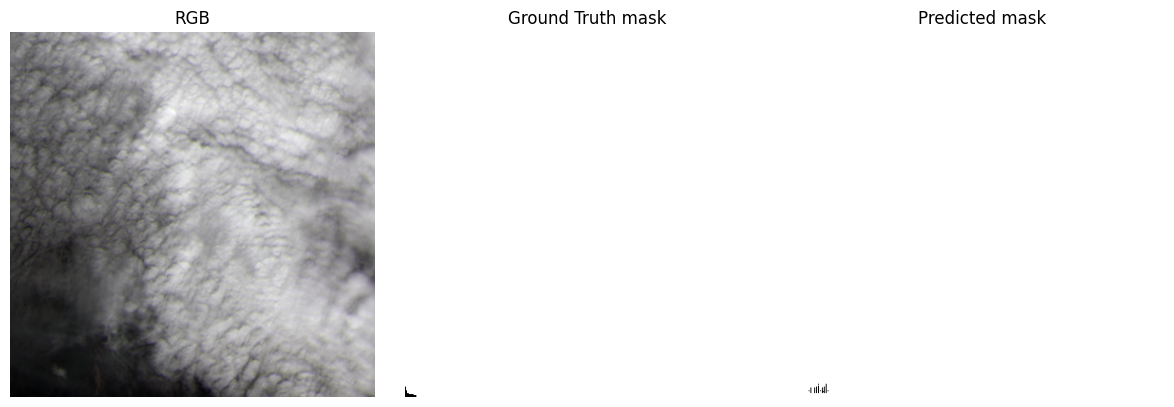

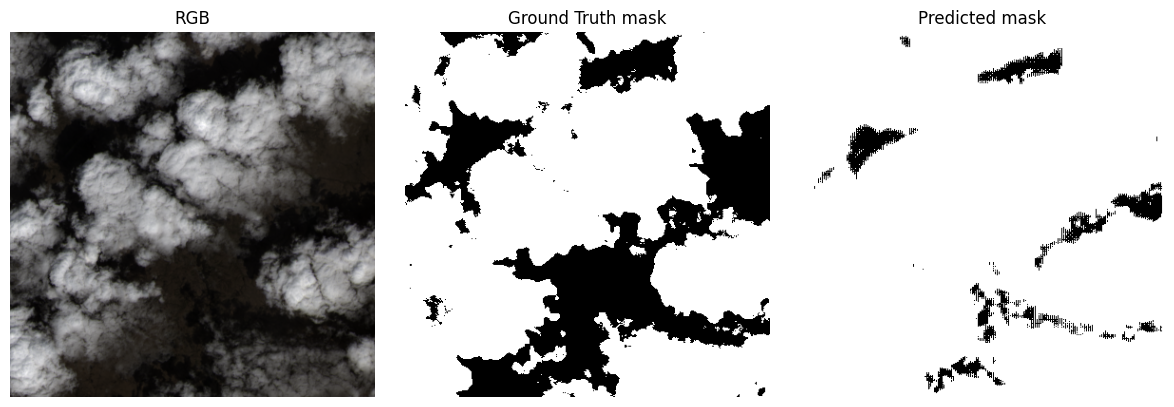

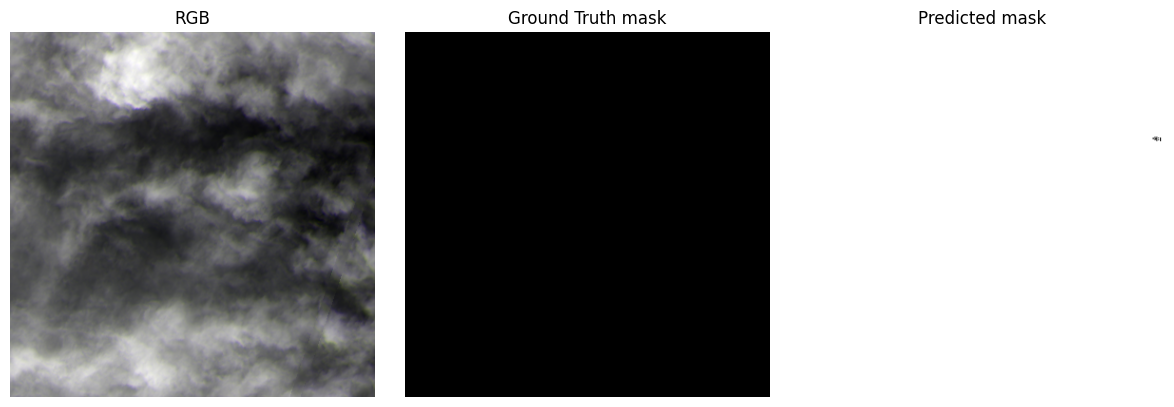

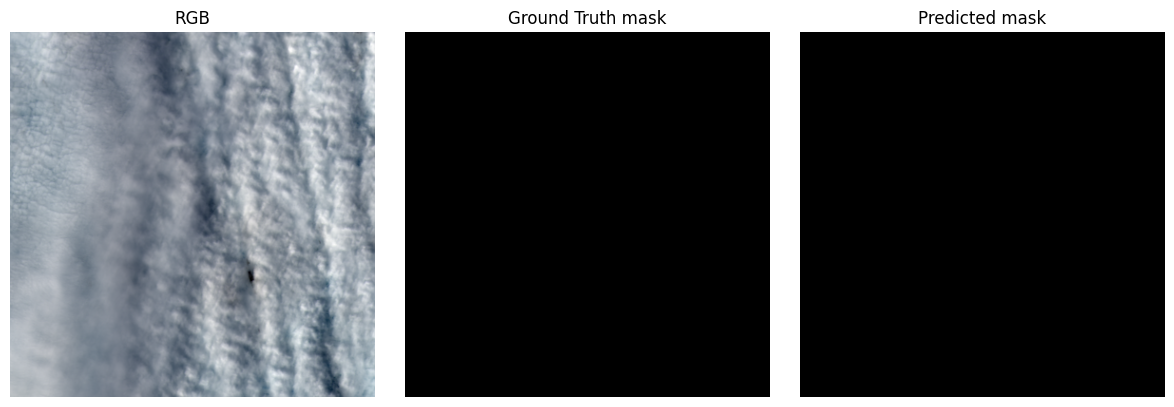

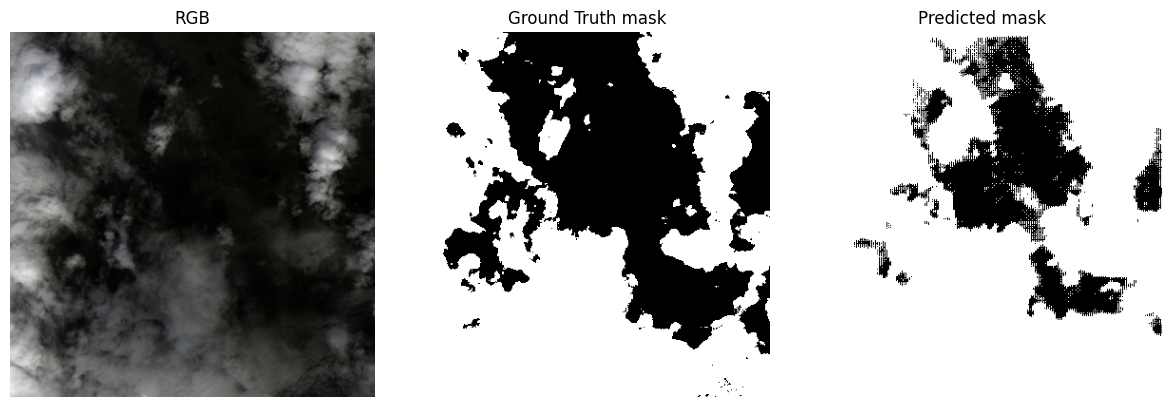

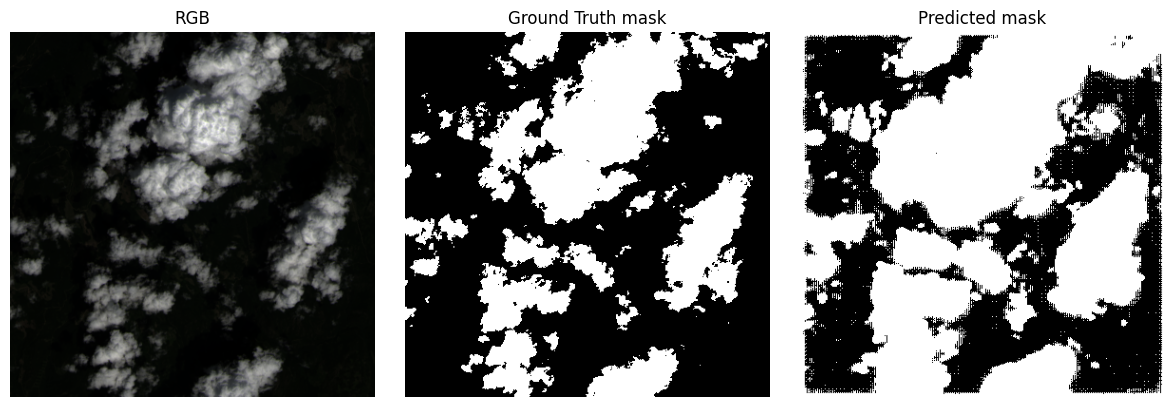

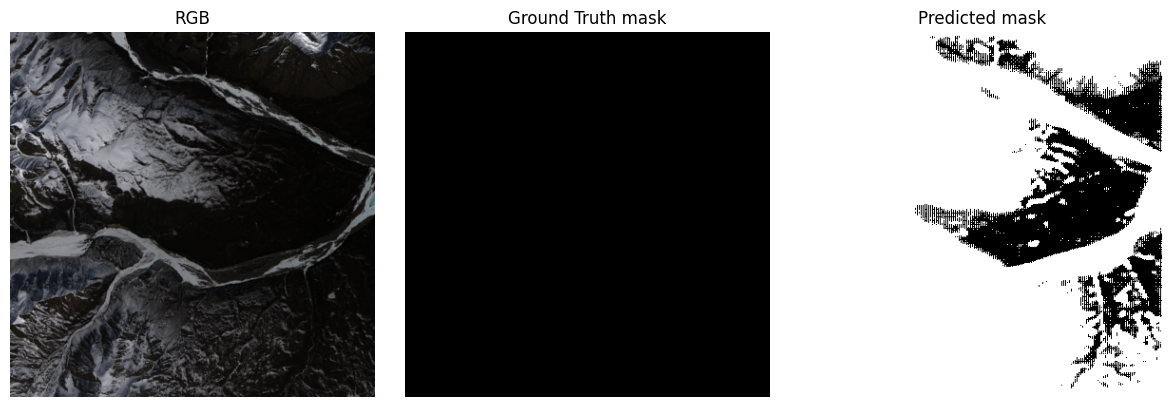

In [52]:
def show_predictions(model: SimpleUNet, dataloader: DataLoader, device: torch.device, num_images: int) -> None:
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > 0.5  # prediction threshold

            for i in range(inputs.size(0)):
                if images_shown >= num_images:
                    return

                rgb = inputs[i, :3].cpu().numpy().transpose(1, 2, 0)
                rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())  # normalize for visualization

                gt_mask = targets[i][0].cpu().numpy()
                pred_mask = preds[i][0].cpu().numpy()

                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                axs[0].imshow(rgb)
                axs[0].set_title("RGB")
                axs[1].imshow(gt_mask, cmap="gray")
                axs[1].set_title("Ground Truth mask")
                axs[2].imshow(pred_mask, cmap="gray")
                axs[2].set_title("Predicted mask")

                for ax in axs:
                    ax.axis("off")

                plt.tight_layout()
                plt.show()

                images_shown += 1


show_predictions(model, dataloader, device, num_images=10)


In [ ]:
torch.save(model.state_dict(), f"{time.strftime('%Y%m%d')}.pth")


In [58]:
model = SimpleUNet(in_channels=3, out_channels=1)
model.load_state_dict(torch.load("20250528.pth"))
model.to(device)
model.eval()


SimpleUNet(
  (enc1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    